In [1]:
# Fit Forward, 6 day gap

In [2]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import random

In [3]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    else:
        thedir = maindir
    return (thedir)

In [4]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [5]:
def read_river_Theodosia(set_primary=False):
    if set_primary:
        nameit = 'Primary River Flow'
    else:
        nameit = 'Secondary River Flow'
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia[nameit] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia[nameit] = theodosia[nameit].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [6]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [7]:
gap_length = 6

In [8]:
def estimate(primary_river, spoint, point, gap_length, ax, fittedbad, fittype, nobad, doplots=True):
    goback = 7
    bad = False
    fitlength = np.array([7, 14, 21, 28])
    ratio = np.zeros(len(fitlength))
    fitted = np.zeros(len(fitlength))
    persist = np.zeros((goback))
    linear = np.zeros((goback-1))
    cubic = np.zeros((goback-2))
    
    if len(primary_river.iloc[spoint-8:spoint]) != 8:
        print (len(primary_river.iloc[spoint-8:spoint]), primary_river.iloc[spoint])
        nobad = nobad + 1
        allbad = True
    else:
        allbad = False
        for ii in range(1, 8):
            jj = ii + gap_length - 1        
            persist[ii-1] = primary_river.iloc[spoint-ii:spoint].mean()
            if ii > 1:
                b, m = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 1)
                linear[ii-2] = b + m * jj
            if ii > 2:
                b, m, c = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 2)
                cubic[ii-3] = b + m * jj + c * jj**2

        if fittype == 'fit':
            useriver = matching_dictionary[river]
        elif fittype == 'backup':
            useriver = backup_dictionary[river]
        firstchoice = read_river(useriver, 'primary')
        for jj, length in enumerate(fitlength):
            for ii in range(length):
                denom = firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values
                if len(denom) == 1:
                    ratio[jj] = ratio[jj] + (primary_river.iloc[spoint-ii].values /
                                firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values)
                else:
                    bad = True
            if not bad:
                numer = firstchoice[firstchoice.index == primary_river.index[point]].values
                if len(numer) != 1:
                    print ('Numer catch')
                    bad = True
                else:
                    fitted[jj] = ratio[jj]/length * firstchoice[firstchoice.index == primary_river.index[point]].values
        if bad:
            fittedbad = fittedbad + 1
        if doplots:
            ax.plot(persist)
            ax.plot(range(1, 7), linear)
            ax.plot(range(2, 7), cubic)
            if not bad:
                ax.plot(fitted)
            ax.plot(primary_river.iloc[spoint-7:spoint].values, 'o')
            ax.plot(7, primary_river.iloc[spoint].values, 'x')
            ax.plot(7+gap_length, primary_river.iloc[point].values, 's')
            ax.grid()
    return (persist, linear, cubic, fitted, bad, fittedbad, allbad, nobad)

In [9]:
def pmhalf(test, value):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt/value < 0.5 or tt/value > 2:
            bads[ii] = True
    return bads

In [10]:
def inbounds(test, maximum, minimum):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt < minimum or tt > maximum:
            bads[ii] = True
    return bads

In [11]:
def docheck(primary_river, point, persist, linear, cubic, fitted, badfit, ax, doplots=True):
    maximum = primary_river['Primary River Flow'].max()
    minimum = primary_river['Primary River Flow'].min()
    value = primary_river.iloc[point].values
    goodness_persist = np.abs(persist - value)
    goodness_linear = np.abs(linear - value)
    goodness_cubic = np.abs(cubic - value)
    if not badfit:
        goodness_fit = np.abs(fitted - value)
        pmfitted = pmhalf(fitted, value)
        ibfitted = inbounds(fitted, maximum, minimum)
    else:
        goodness_fit = np.zeros((4))
        pmfitted = np.zeros((4))
        ibfitted = np.zeros((4))
    if doplots:
        ax.plot(goodness_persist, 'o')
        ax.plot(goodness_linear, 'o')
        ax.plot(goodness_cubic, 'o')
        if not badfit:
            ax.plot(goodness_fit, 'o')
        ax.grid()
    return (np.concatenate((goodness_persist, goodness_linear, goodness_cubic, goodness_fit)), 
            np.concatenate((pmhalf(persist, value), pmhalf(linear, value), pmhalf(cubic, value), pmfitted)),
            np.concatenate((inbounds(persist, maximum, minimum), inbounds(linear, maximum, minimum), 
                            inbounds(cubic, maximum, minimum), ibfitted)))

In [12]:
def doone(primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, fittype, nobad, doplots=True):

    point = random.randrange(len(primary_river.index))
    spoint = point - gap_length + 1
    
    if doplots:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        primary_river.iloc[point-10:point+1].plot(ax=axs[0], marker='s')
    else:
        axs = [0, 1, 2]

    (persist, linear, cubic, fitted, badfit, fittedbad, allbad, nobad) = estimate(
        primary_river, spoint, point, gap_length, axs[1], fittedbad, fittype, nobad, doplots)

    if not allbad:
        GG, CC, BB = docheck(primary_river, point, persist, linear, cubic, fitted, badfit, axs[2], doplots)
        accumulateG += GG
        accumulateC += CC
        accumulateB += BB
    
    
    return accumulateG, accumulateC, accumulateB, fittedbad, nobad

In [13]:
print (gap_length)

6


In [14]:
river = 'Homathko_Mouth'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

Numer catch
realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  962.  962.  962.  962.] [ 92.34427406  93.2720223   93.63049561  93.02745788  92.39658148
  92.13116347  92.13649669 236.38299362 212.67540826 197.03512326
 182.18453065 170.40027444 166.04219277 879.05004311 746.54514724
 600.06634518 529.86026368 463.5303802   56.82913231  60.89723014
  64.07346228  68.31217697] [0.107      0.102      0.106      0.103      0.101      0.106
 0.105      0.379      0.364      0.347      0.345      0.316
 0.318      0.637      0.621      0.589      0.599      0.558
 0.04781705 0.04989605 0.06340956 0.06548857] [0.        0.        0.        0.        0.        0.        0.
 0.12      0.108     0.082     0.078     0.07      0.065     0.313
 0.307     0.279     0.272     0.24      0.0010395 0.002079  0.002079
 0.0010395]


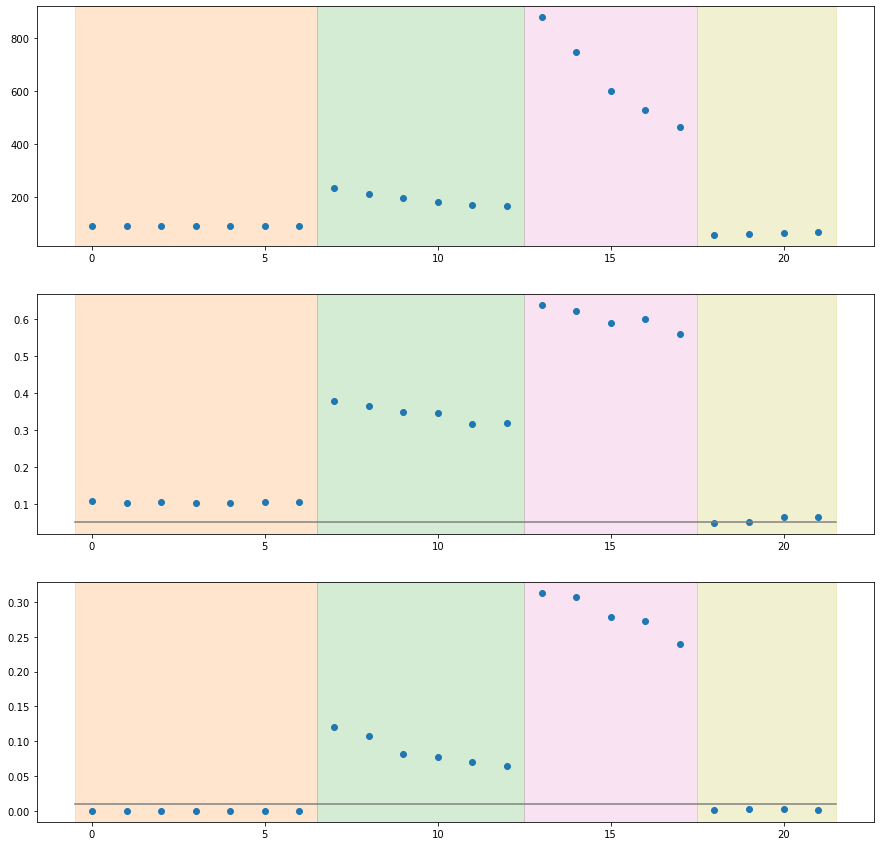

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [16]:
print (gap_length)

6


In [17]:
river = 'Squamish_Brackendale'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

Numer catch
Numer catch
Numer catch
Numer catch
realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  884.  884.  884.  884.] [ 101.87663053  104.95254704  105.37145335  104.93881598  104.43569966
  104.50959302  105.0013538   300.34132607  252.18019466  228.25755518
  207.50005328  193.02027015  185.15548409 1376.35538246  939.06699908
  740.58879966  622.56187902  533.47306872   58.12966492   60.97986285
   62.56413653   66.67494917] [0.178      0.194      0.2        0.202      0.202      0.212
 0.22       0.573      0.546      0.508      0.496      0.47
 0.468      0.8        0.793      0.773      0.736      0.736
 0.05656109 0.05769231 0.06108597 0.06334842] [0.    0.    0.    0.    0.    0.    0.    0.245 0.191 0.181 0.15  0.134
 0.13  0.403 0.387 0.361 0.324 0.303 0.    0.    0.    0.   ]


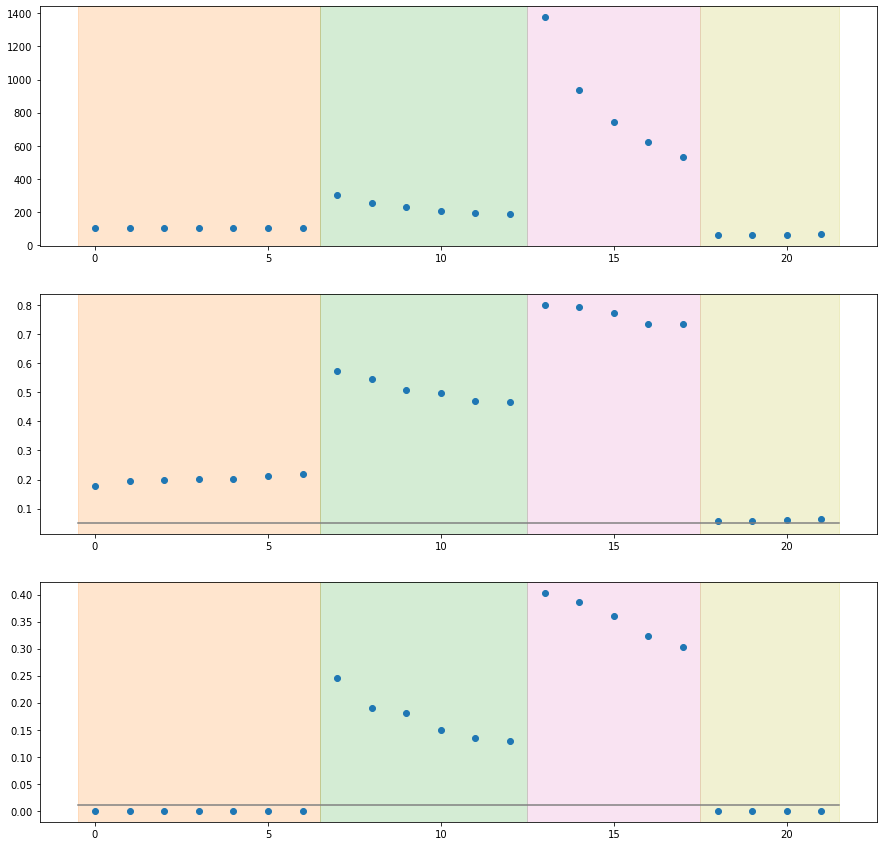

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [19]:
river = 'Snohomish_Monroe'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  998.  998.  998.  998.] [ 143.99919581  147.59306417  148.27993964  148.24392475  148.1330331
  147.27881713  145.43332256  360.43209413  331.84631528  321.56072524
  299.12512955  276.07416899  256.53183591 1616.12727784 1137.05450393
  906.82972973  803.95554891  741.74011094   76.46234237   77.41829052
   78.67924114   81.57333033] [0.179      0.186      0.189      0.192      0.199      0.198
 0.201      0.488      0.452      0.457      0.432      0.43
 0.429      0.708      0.68       0.626      0.628      0.625
 0.04008016 0.05511022 0.06212425 0.06412826] [0.    0.    0.    0.    0.    0.    0.    0.186 0.152 0.134 0.117 0.104
 0.092 0.331 0.32  0.289 0.265 0.277 0.    0.    0.    0.   ]


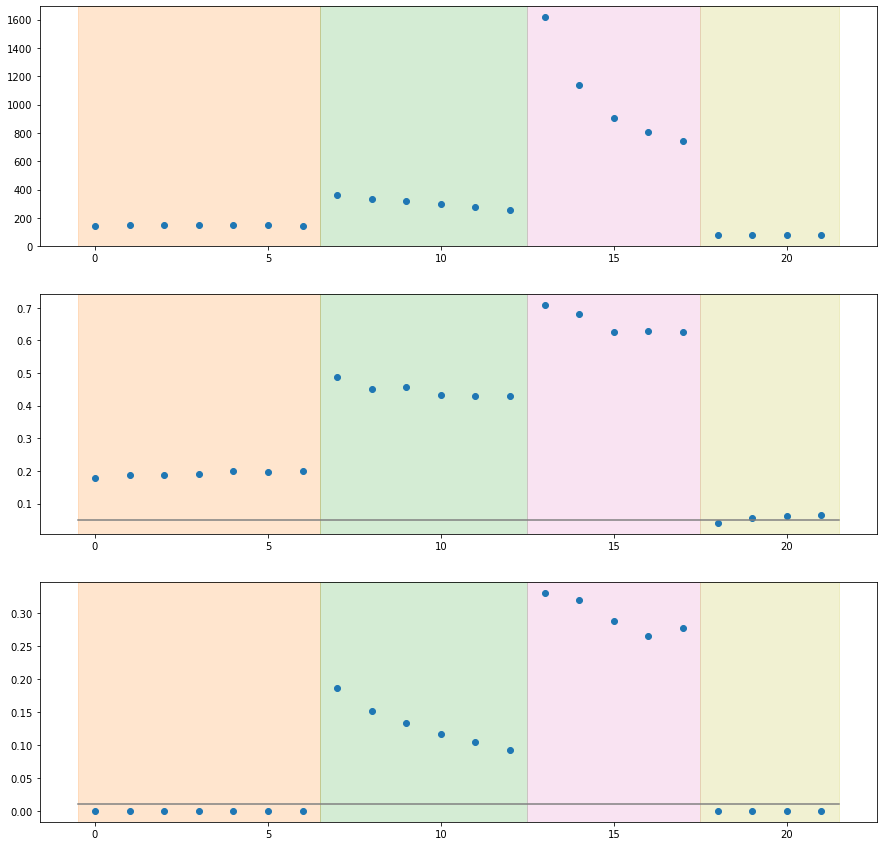

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [21]:
river = 'Skagit_MountVernon'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  998.  998.  998.  998.] [ 139.7768193   138.98862105  137.1456189   137.21832248  137.38070656
  138.00116502  138.27181914  391.2249031   340.58593548  321.79169055
  300.31580224  282.82549363  269.13523159 1688.4418626  1187.94608917
  974.97821611  840.49396843  721.85725241  149.13471063  151.75731111
  158.88652973  169.56072612] [0.062      0.064      0.063      0.06       0.061      0.058
 0.058      0.38       0.355      0.322      0.292      0.265
 0.257      0.732      0.686      0.637      0.603      0.573
 0.05210421 0.05410822 0.05511022 0.06412826] [0.         0.         0.         0.         0.         0.
 0.         0.166      0.137      0.126      0.107      0.091
 0.08       0.394      0.362      0.35       0.32       0.291
 0.00501002 0.00701403 0.00200401 0.00300601]


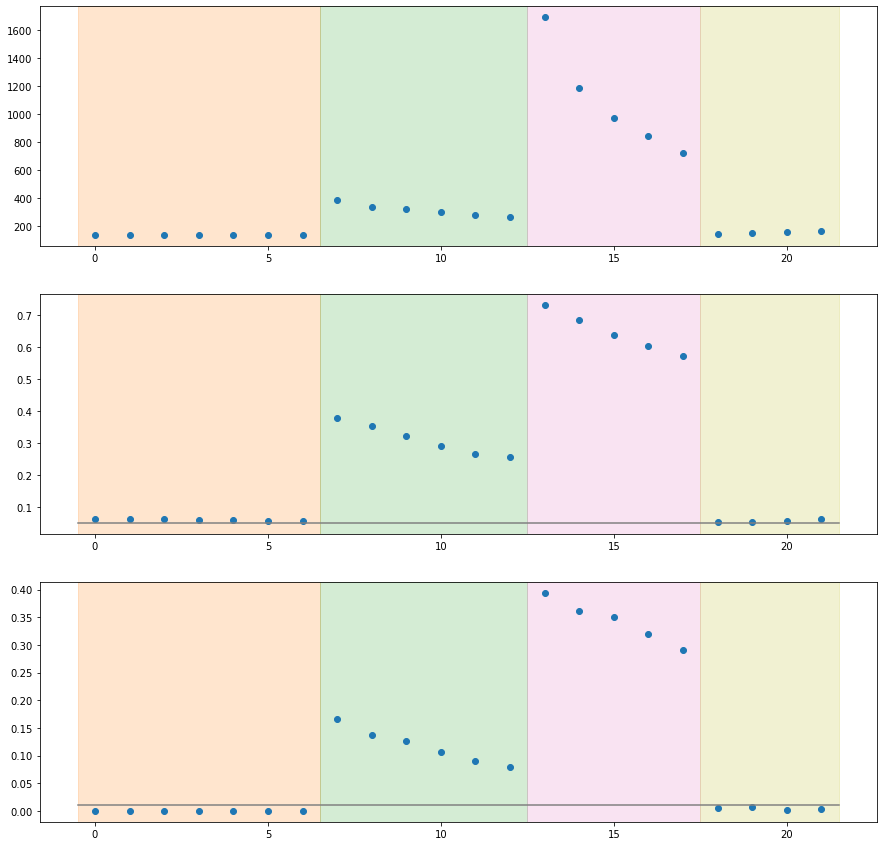

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [23]:
river = 'Greenwater_Greenwater'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  994.  994.  994.  994.] [ 2.39294509  2.41740089  2.45507782  2.51111111  2.57082447  2.65639755
  2.73898775  5.076653    4.64858338  4.36029022  4.08250435  4.17222861
  4.17452812 17.49240236 15.32953577 12.61345288 11.88110974 10.67216804
  1.46860983  1.50570813  1.52384363  1.56980455] [0.094      0.094      0.097      0.1        0.104      0.118
 0.121      0.251      0.254      0.256      0.238      0.238
 0.224      0.479      0.448      0.427      0.439      0.441
 0.04527163 0.04426559 0.04627767 0.04527163] [0.         0.         0.         0.         0.         0.
 0.         0.061      0.061      0.06       0.055      0.047
 0.047      0.228      0.197      0.195      0.199      0.187
 0.00503018 0.00301811 0.00201207 0.00100604]


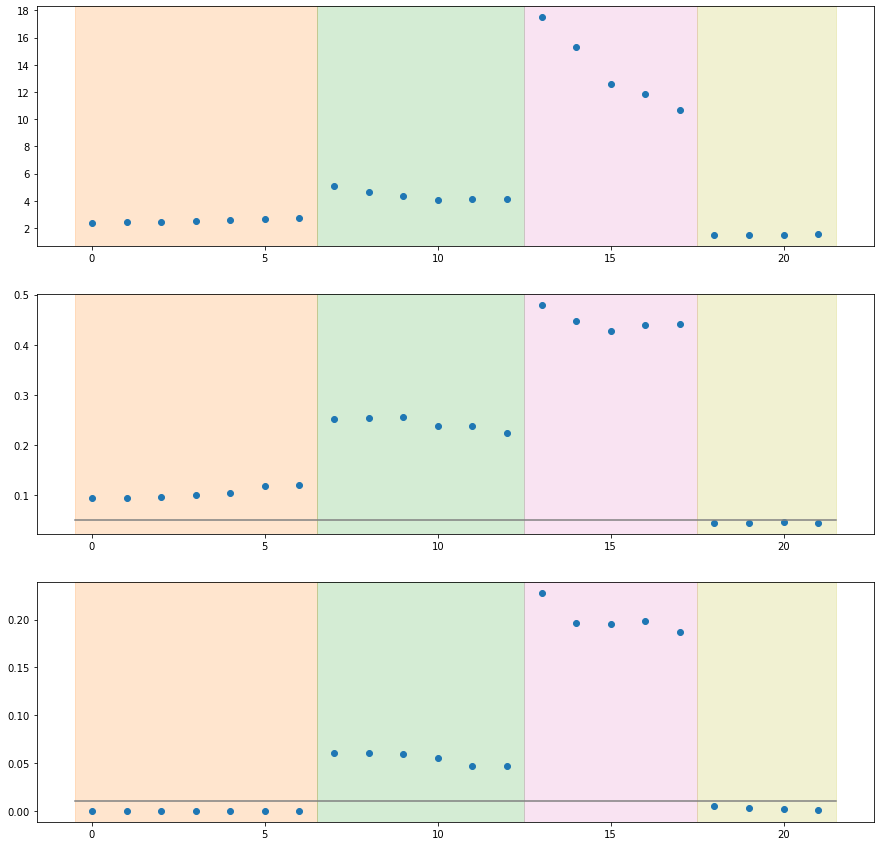

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');